In [2]:
%matplotlib inline




# Representational Similarity Analysis


Representational Similarity Analysis is used to perform summary statistics
on supervised classifications where the number of classes is relatively high.
It consists in characterizing the structure of the confusion matrix to infer
the similarity between brain responses and serves as a proxy for characterizing
the space of mental representations [1]_ [2]_ [3]_.

In this example, we perform RSA on responses to 24 object images (among
a list of 92 images). Subjects were presented with images of human, animal
and inanimate objects [4]_. Here we use the 24 unique images of faces
and body parts.

<div class="alert alert-info"><h4>Note</h4><p>this example will download a very large (~6GB) file, so we will not
          build the images below.</p></div>

References
----------

.. [1] Shepard, R. "Multidimensional scaling, tree-fitting, and clustering."
       Science 210.4468 (1980): 390-398.
.. [2] Laakso, A. & Cottrell, G.. "Content and cluster analysis:
       assessing representational similarity in neural systems." Philosophical
       psychology 13.1 (2000): 47-76.
.. [3] Kriegeskorte, N., Marieke, M., & Bandettini.  P. "Representational
       similarity analysis-connecting the branches of systems neuroscience."
       Frontiers in systems neuroscience 2 (2008): 4.
.. [4] Cichy, R. M., Pantazis, D., & Oliva, A. "Resolving human object
       recognition in space and time." Nature neuroscience (2014): 17(3),
       455-462.



In [1]:
# Authors: Jean-Remi King <jeanremi.king@gmail.com>
#          Jaakko Leppakangas <jaeilepp@student.jyu.fi>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

import os.path as op
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories


print(__doc__)

data_path = visual_92_categories.data_path()

# Define stimulus - trigger mapping
fname = op.join(data_path, 'visual_stimuli.csv')
conds = read_csv(fname)
print(conds.head(5))

Automatically created module for IPython interactive environment
   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1


Let's restrict the number of conditions to speed up computation



In [3]:
max_trigger = 24
conds = conds[:max_trigger]  # take only the first 24 rows

Define stimulus - trigger mapping



In [4]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))
print(conditions[:10])

['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']


Let's make the event_id dictionary



In [5]:
event_id = dict(zip(conditions, conds.trigger + 1))
event_id['0/human bodypart/human/not-face/animal/natural']

1

Read MEG data



In [6]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)

events = events[events[:, 2] <= max_trigger]

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


Epoch data



In [7]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True)

720 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 720 events and 601 original time points ...
0 bad epochs dropped


Let's plot some conditions



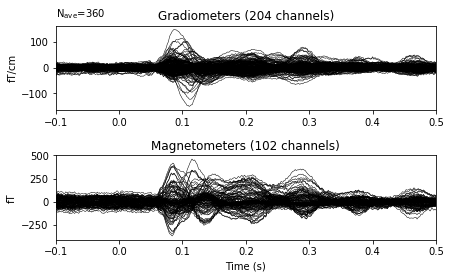

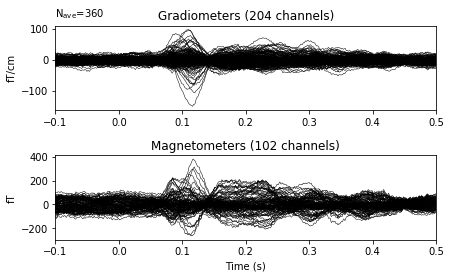

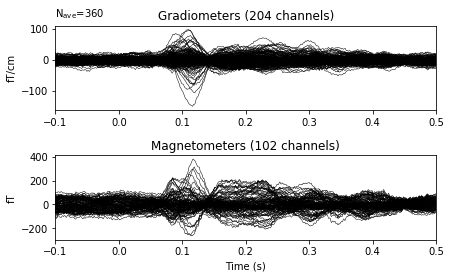

In [8]:
epochs['face'].average().plot()
epochs['not-face'].average().plot()

Representational Similarity Analysis (RSA) is a neuroimaging-specific
appelation to refer to statistics applied to the confusion matrix
also referred to as the representational dissimilarity matrices (RDM).

Compared to the approach from Cichy et al. we'll use a multiclass
classifier (Multinomial Logistic Regression) while the paper uses
all pairwise binary classification task to make the RDM.
Also we use here the ROC-AUC as performance metric while the
paper uses accuracy. Finally here for the sake of time we use
RSA on a window of data while Cichy et al. did it for all time
instants separately.



In [9]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(C=1, solver='liblinear',
                                       multi_class='auto'))
X = epochs.copy().crop(0.05, 0.3).get_data().mean(axis=2)
y = epochs.events[:, 2]

classes = set(y)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y), len(classes)))
for train, test in cv.split(X, y):
    # Fit
    clf.fit(X[train], y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

Compute confusion matrix using ROC-AUC



In [10]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

Plot



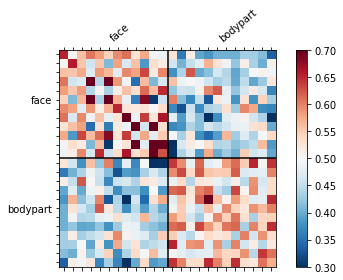

In [11]:
labels = [''] * 5 + ['face'] + [''] * 11 + ['bodypart'] + [''] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(11.5, color='k')
ax.axvline(11.5, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

Confusion matrix related to mental representations have been historically
summarized with dimensionality reduction using multi-dimensional scaling [1].
See how the face samples cluster together.



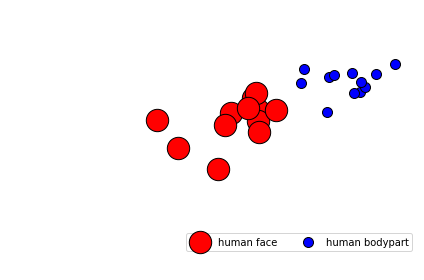

In [12]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()